# Signal Processing and Machine Learning for Finance Coursework

## Table of Contents
1 [Regression Methods](#1)  
1.1 [Processing Stock Price Data in Python](#1.1)  
1.2 [ARMA vs. ARIMA Models for Financial Applications](#1.2)  
1.3 [Vector Autoregressive (VAR) Models](#1.3)  
  
2 [Bond Pricing](#2)  
2.1 [Examples](#2.1)  
2.2 [Forward Rates](#2.2)  
2.3 [Duration of a Coupon-Bearing Bond](#2.3)  
2.4 [Capital Asset Pricing Model (CAPM) and Arbitrage Pricing Theory (APT)](#2.4)  
  
3 [Portfolio Optimization](#3)  
3.1 [Adaptive Minimum-Variance Portfolio Optimization](#3.1)  
  
4 [Robust Statistics and Non Linear Methods](#4)  
4.1 [Data Import and Exploratory Data Analysis](#4.1)  
4.2 [Robust Estimators](#4.2)  
4.3 [Robust and OLS Regression](#4.3)  
4.4 [Robust Trading Strategies](#4.4)  
  
5 [Graphs in Finance](#5)  

In [ ]:
import numpy as np #scientific library
import pandas as pd #data structure library
import matplotlib.pyplot as plt #plotting library
%matplotlib inline

from scipy import stats #stats library
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
import copy
from statsmodels.tsa.api import VAR
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.decomposition import PCA
import time
import networkx as nx

# Regression Methods  <a class="anchor" id="1"></a>

## Processing Stock Price Data in Python <a class="anchor" id="1.1"></a>

### Natural log plot

In [ ]:
file = pd.read_csv("assets/priceData.csv")
priceData = file.dropna(axis=0)
px = priceData["SPX Index"]
date = priceData["date"]

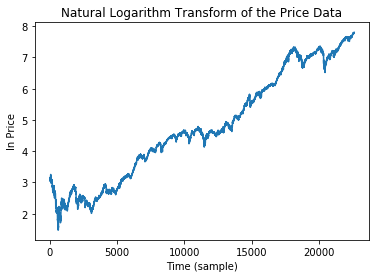

In [ ]:
logpx = np.log(px)
logpx.plot()
plt.title('Natural Logarithm Transform of the Price Data')
plt.xlabel('Time (sample)')
plt.ylabel('ln Price');

### Sliding window

The sliding window on the price time series captures the exponential trend of the stock market while on the log price time series it captures the variance pratically in terms of the growth in capital over time. Hence, the stationary points in the variance time-series describes the moments of economic decline.

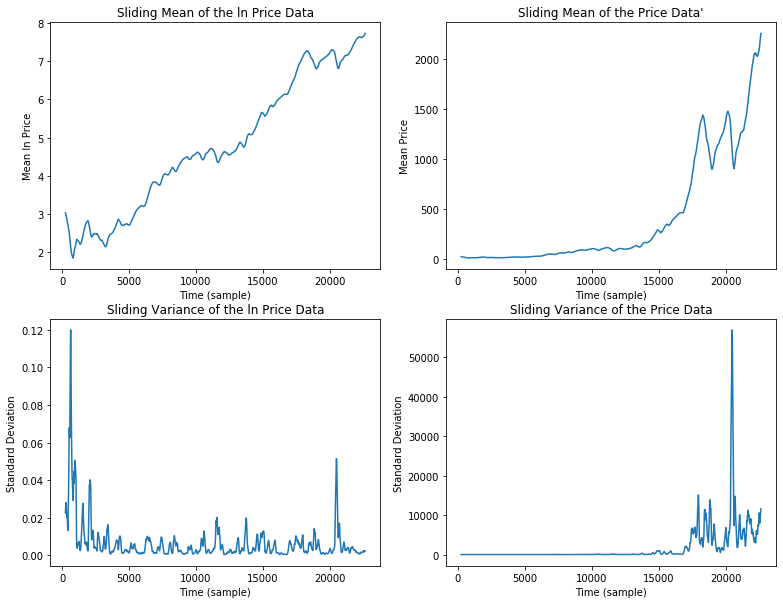

In [ ]:
#sliding mean
fig = plt.figure(figsize=(13,10))
ax1 = fig.add_subplot(221)
ax1.set_xlabel('Time (sample)')
ax1.set_ylabel('Mean ln Price')
ax1.set_title("Sliding Mean of the ln Price Data")
logpx.rolling(252).mean().plot()

#sliding standard deviation
ax2 = fig.add_subplot(223)
ax2.set_xlabel('Time (sample)')
ax2.set_ylabel('Standard Deviation')
ax2.set_title("Sliding Variance of the ln Price Data")
logpx.rolling(252).var().plot()


ax3 = fig.add_subplot(222)
ax3.set_xlabel('Time (sample)')
ax3.set_ylabel('Mean Price')
ax3.set_title("Sliding Mean of the Price Data'")
px.rolling(252).mean().plot()

ax4 = fig.add_subplot(224)
ax4.set_xlabel('Time (sample)')
ax4.set_ylabel('Standard Deviation')
ax4.set_title("Sliding Variance of the Price Data")
px.rolling(252).var().plot()
plt.show()

### Returns

The advantage of using returns plotted below instead of the price data seen in Section 1.1.1 is its stationarity as opposed to the non-stationary charateristic of the natural log price time-series. This stationarity makes it easier to detect and extract trends and thus the difference in its simple and log plots is minute (behaviour of log on small values below 1).

In [ ]:
#log return
logret = logpx.diff()

#simple return
simpret = px.pct_change()

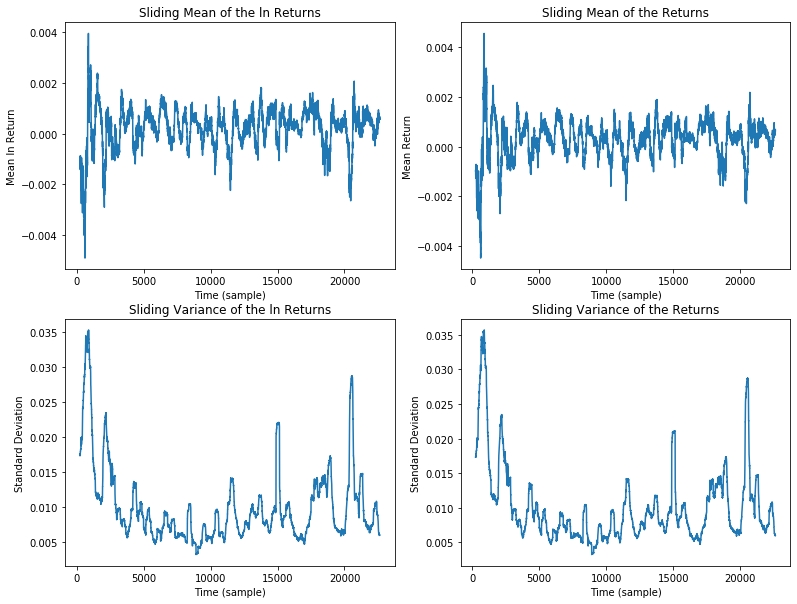

In [ ]:
fig = plt.figure(figsize=(13,10))

#return sliding statistics
ax1 = fig.add_subplot(221)
ax1.set_xlabel('Time (sample)')
ax1.set_ylabel('Mean ln Return')
ax1.set_title("Sliding Mean of the ln Returns")
logret.rolling(252).mean().plot()

ax2 = fig.add_subplot(223)
ax2.set_xlabel('Time (sample)')
ax2.set_ylabel('Standard Deviation')
ax2.set_title("Sliding Variance of the ln Returns")
logret.rolling(252).std().plot()

ax3 = fig.add_subplot(222)
ax3.set_xlabel('Time (sample)')
ax3.set_ylabel('Mean Return')
ax3.set_title("Sliding Mean of the Returns")
simpret.rolling(252).mean().plot()

ax4 = fig.add_subplot(224)
ax4.set_xlabel('Time (sample)')
ax4.set_ylabel('Standard Deviation')
ax4.set_title("Sliding Variance of the Returns")
simpret.rolling(252).std().plot()
plt.show()

### Jarque-Bera test

Theoretically, the log returns are preferred over their simple counterparts due to time additivity (eg. Section 1.1.5), numerical stability and tractability, its resistance to outliers and its normalization property.

Practically, the Jarque-Bera test shows log returns are no closer to a Gaussian model than the simple returns which is expected as the prices are not log normally distributed

In [ ]:
[jp_val_simp, p_val_simp] = stats.jarque_bera(simpret.dropna())
p_val_simp

0.0

In [ ]:
[jp_val_log,p_val_log] = stats.jarque_bera(logret.dropna())
p_val_log

0.0

### Simple and logarithmic returns

If the price rises from a £1 to £2 then declines back to £1, the simple returns would be $\frac{p[t]-p[t-1]}{p[t-1]} = \frac{2-1}{1} = 1$ and $-0.5$. On the other hand, the log returns would be $log(p[t])-log(p[t-1]) = log(2/1) = 0.693$ and $0.693$ proving its property of additivity through time. 

### Simple over logarithmic returns

Many scenarios result in the favouring of simple returns. For example, the simple return of the portfolio is the weighted simple returns of the portfolio's assets. In contrast, this is not the case for portfolio log returns which can only be estimated. Additionally, this means beta of the CAPM should not be built using log returns either. Hence, once the return is applied with a logarithm it cannot be truly classed as a return anymore.

## ARMA vs. ARIMA Models for Financial Applications <a class="anchor" id="1.2"></a>

### Log price time series of S&P 500 index
From the figure below, it is evident the time series is non-stationary and thus ARIMA would be better for modelling. 

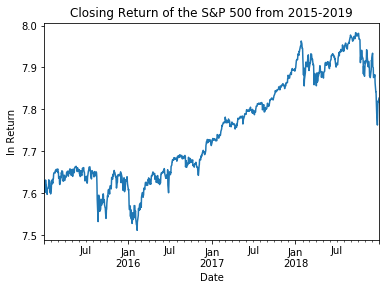

In [ ]:
snp = pd.read_csv('assets/snp_500_2015_2019.csv')
snp.set_index(["Date"], inplace=True)
snp.index = pd.DatetimeIndex(snp.index).to_period('D')
snp_close = snp["Close"].to_frame().apply(np.log)
snp_close.plot(legend=False)
plt.title('Closing Return of the S&P 500 from 2015-2019')
plt.ylabel('ln Return');

### Fitting an ARMA model
Inspecting the model parameters, the model is shown to be not useful in practice as it takes almost ($0.997$ of) the past true time sample and overlays it with white noise. Increasing the order of the model proved no different as the first coefficient overpowered the other coefficients hence producing similar results.

In [ ]:
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ["True"]
model = ARIMA(snp_arma, order = (1,0,0)).fit()
snp_arma["Res"] = model.resid
snp_arma["Prediction"] = snp_arma["True"] - snp_arma["Res"]

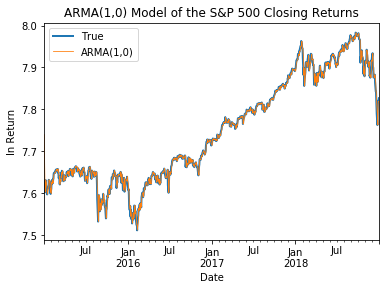

In [ ]:
snp_close.plot(linewidth = 2,legend=False)
snp_arma["Prediction"].plot(linewidth = 0.8)
plt.title('ARMA(1,0) Model of the S&P 500 Closing Returns');
plt.ylabel('ln Return');
plt.legend(['True','ARMA(1,0)']);

In [ ]:
model.params

const         7.739998
ar.L1.True    0.997359
dtype: float64

### Fitting an ARIMA model

As evidenced, the ARIMA model is no better than the ARMA model in its forecasting. The integrating factor is insufficient in removing the non-stationarities of the time-series as thus produces a model no physically more meaningful.

In [ ]:
snp_arima = copy.deepcopy(snp_close)
snp_arima.columns = ["True"]
arima_model = ARIMA(snp_arima, order = (1,1,0)).fit()
snp_arima["Res"] = arima_model.resid
snp_arima["Prediction"] = snp_arima["True"] - snp_arima["Res"]

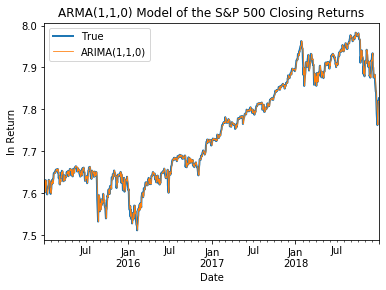

In [ ]:
snp_close.plot(linewidth = 2,legend=False)
snp_arima["Prediction"].plot(linewidth = 0.8)
plt.title('ARMA(1,1,0) Model of the S&P 500 Closing Returns');
plt.ylabel('ln Return');
plt.legend(['True','ARIMA(1,1,0)']);

In [ ]:
arima_model.params

const           0.000196
ar.L1.D.True   -0.008751
dtype: float64

### Log prices for ARIMA model

As mentioned before, there are many advantages to using log prices over simple prices. For the purposes of an ARIMA model, it is due to proportions being more stationary/stable than the absolute differences and thus are better suited.

## Vector Autoregressive (VAR) Models <a class="anchor" id="1.3"></a>

### Concise matrix form

The vector autoregressive (VAR) process can be captured in the form:

\begin{equation}
    \textbf{Y} = \textbf{B} \textbf{Z} + \textbf{U}
\end{equation}

where:
\begin{equation}
    \textbf{Y} =
    \begin{pmatrix}
        y_{1,t-1} & y_{1,t-2} & \cdots & y_{1,0} \\
        y_{2,t-1} & y_{2,t-2} & \cdots & y_{2,0} \\
        \vdots    &   \vdots  & \ddots &  \vdots \\
        y_{k,t-1} & y_{k,t-2} & \cdots & y_{k,0} \\ 
    \end{pmatrix}
\end{equation}
    
\begin{equation}
    \textbf{B} =
    \begin{pmatrix}
        c_{1}   &  a_{1,1}^{1} & a_{1,2}^{1} & \cdots & a_{1,k}^{1} & a_{1,1}^{2} \cdots & a_{1,k}^{p} \\
        c_{2}   &  a_{2,1}^{1} & a_{2,2}^{1} & \cdots & a_{2,k}^{1} & a_{2,1}^{2} \cdots & a_{2,k}^{p} \\
        \vdots  &  \vdots      &     \vdots  & \ddots &     \vdots  &  \vdots\quad\ddots &      \vdots \\
        c_{k}   &  a_{k,1}^{1} & a_{k,2}^{1} & \cdots & a_{k,k}^{1} & a_{k,1}^{2} \cdots & a_{k,k}^{p} \\ 
    \end{pmatrix}
\end{equation}

\begin{equation}
    \textbf{Z} =
    \begin{pmatrix}
            1         &        1      & \cdots &         1     \\
        y_{1,t-1}^{1} & y_{1,t-2}^{1} & \cdots & y_{1,t-p}^{1} \\
        y_{2,t-1}^{1} & y_{2,t-2}^{1} & \cdots & y_{2,t-p}^{1} \\
        \vdots        &       \vdots  & \ddots &        \vdots \\
        y_{k,t-1}^{1} & y_{k,t-2}^{1} & \cdots & y_{k,t-p}^{1} \\
        y_{1,t-1}^{2} & y_{1,t-2}^{2} & \cdots & y_{1,t-p}^{2} \\
        \vdots        &       \vdots  & \ddots &     \vdots    \\
        y_{k,t-1}^{p} & y_{k,t-2}^{p} & \cdots & y_{k,t-p}^{p} \\ 
    \end{pmatrix}
\end{equation}

\begin{equation}
    \textbf{U} =
    \begin{pmatrix}
        e_{1,t-1} & e_{1,t-2} & \cdots & e_{1,0} \\
        e_{2,t-1} & e_{2,t-2} & \cdots & e_{2,0} \\
        \vdots    &  \vdots   & \ddots &  \vdots \\
        e_{k,t-1} & e_{k,t-2} & \cdots & e_{k,0} \\ 
    \end{pmatrix}
\end{equation}

### Optimal coefficients

To find the optimal set of coefficients the cost function:

\begin{equation}
    J(\textbf{B}) = (\textbf{Y} - \textbf{BZ})^T(\textbf{Y} - \textbf{BZ})
\end{equation}

needs to be minimized by:
\begin{equation}
    \frac{d}{d\textbf{B}} J(\textbf{B}) = 0
\end{equation}

Expanding the cost function the following is obtained:

\begin{equation}
    J(\textbf{B}) = \textbf{YY}^{T} - 2\textbf{Y}^T\textbf{BZ} + \textbf{Z}^T\textbf{B}^{T}\textbf{BZ}
\end{equation}

and after its derivative w.r.t. $\textbf{B}$ is:

\begin{equation}
    \frac{d}{d\textbf{B}} J(\textbf{B}) = -2\textbf{YZ}^T + \textbf{B}(\textbf{ZZ}^T+\textbf{ZZ}^T)
\end{equation}

\begin{equation}
    \frac{d}{d\textbf{B}} J(\textbf{B}) = -2\textbf{YZ}^T + 2\textbf{B}\textbf{ZZ}^T
\end{equation}

Solving for $\textbf{B}_{opt}$ by equating to $0$ the proof is completed:

\begin{equation}
    0 = -2\textbf{YZ}^T + 2\textbf{B}_{opt}\textbf{ZZ}^T
\end{equation}

\begin{equation}
    \textbf{B}_{opt} = \textbf{YZ}^T(\textbf{ZZ}^T)^{-1}
\end{equation}

### Stability for a VAR process

For a VAR(1) process:

\begin{equation}
    \textbf{y}_{t} = \textbf{Ay}_{t-1} + \textbf{e}_{t}
\end{equation}

the future time instant $n$ is given by:

\begin{equation}
    \textbf{y}_{t+n} = \textbf{A}^{n+1}\textbf{y}_{t-1} + \textbf{e}_{t+n}
\end{equation}

For the case where $\textbf{A}$ is diagonalizable, the first element of the process can be written as a linear combination:

\begin{equation}
    y_{1,t+n} = \lambda_1^{n} v_1 y_{1,t-1} + \cdot +  \lambda_k^{n} v_k y_{k,t-1} + \textbf{e}_{1,t+n}
\end{equation}

It can be seen as $n$ increases, if $|\lambda|>1$ the term explodes and hence will not reach stability.

### MA model detrending and VAR model fitting 

Judging from the plot, it can be said the stocks selected for the portfolio are neither strongly correlated or highly independent often relied upon in portfolio optimization. Therefore, it would make little sense to invest in the assets from various sectors given. It can also be noted the VAR model is unstable as the third eigenvalue is $1.006$. 

In [ ]:
df = pd.read_csv(r'assets/snp_allstocks_2015_2019.csv')
df = df.set_index("Date") # same as df.set_index(["Date"], inplace=True)
df.index = pd.DatetimeIndex(df.index).to_period('D')

info = pd.read_csv(r'assets/snp_info.csv')
info.drop(columns = info.columns[0], inplace = True)

In [ ]:
tickers = ['CAG', 'MAR', 'MAR', 'LIN', 'HCP', 'MAT']
stocks = df[tickers]
stocks_ma = stocks.rolling(window = 66).mean()
stocks_detrended = stocks.sub(stocks_ma).dropna()

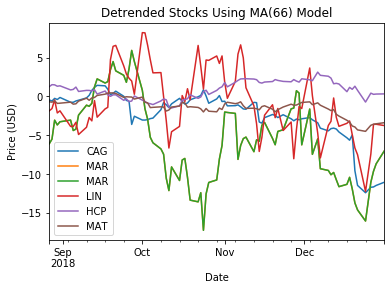

In [ ]:
stocks_detrended.plot()
plt.title('Detrended Stocks Using MA(66) Model');
plt.ylabel('Price (USD)');

In [ ]:
model = VAR(stocks_detrended)
results = model.fit(1)
A = results.params[1:].values
eigA,_ = np.linalg.eig(A)
print(abs(eigA))

[7.26093929e-01 7.26093929e-01 1.00635964e+00 8.60518943e-01
 9.11445115e-01 8.51909181e-17]


### Sector grouping

Building a portfolio with assets from a mutual sector increases external risk but lowers internal risk. A negative event for the sector will cause all stocks within the sector to plummet and vice versa. However, the interaction within the sector will often offset one another as one company's gain may be in direct correlation to another company's loss. Therefore, it is generally advisable to not invest in solely one sector but instead have a diversified approach. For modelling, assets from a single industry makes the VAR process more stable as evidenced by the eigenvalues below 1. This is due to their correlation, providing valuable information about the overall performance of the sector.

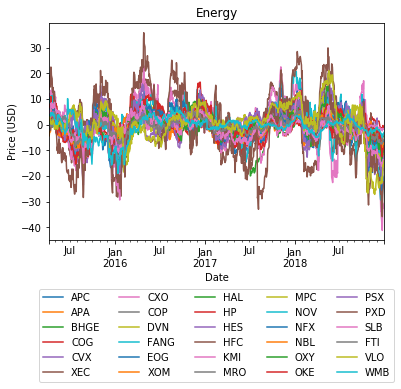

In [ ]:
for sector in info['GICS Sector'].unique():
    tickers = info.loc[info['GICS Sector']==sector]['Symbol'].tolist()
    stocks = df[tickers]
    stocks_ma = stocks.rolling(window=66).mean()
    stocks_detrended = stocks.sub(stocks_ma).dropna()
    #stocks_detrended.plot() #uncomment to view detrend stocks from all sectors
    #plt.title(sector)
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)
    
stocks_detrended.plot()
plt.title(sector)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5);
plt.ylabel('Price (USD)');

In [ ]:
model = VAR(stocks_detrended)
results = model.fit(1)
A = results.params[1:].values
eigA,_ = np.linalg.eig(A)
print(abs(eigA))

[0.85529059 0.85529059 0.8257071  0.85761354 0.85761354 0.89552856
 0.89552856 0.87763887 0.91651149 0.91651149 0.90201659 0.90201659
 0.91742369 0.91742369 0.97393176 0.97393176 0.95686851 0.95686851
 0.96641914 0.96641914 0.97896334 0.97896334 0.97991243 0.97991243
 0.98557732 0.97921004 0.97921004 0.94204081 0.97301684 0.95468189]


# Bond Pricing <a class="anchor" id="2"></a>

## Examples of Bond Pricing <a class="anchor" id="2.1"></a>

### Types of compounding
The following equations describe the different forms of compounding:

\begin{equation}\label{eq:annual_compounding}
r_1 = P \times (1+r_f) \quad \text{Annual compounding} 
\end{equation}
\begin{equation}\label{eq:semi_compounding}
r_1 = P \times (1+\frac{r_f}{2})^2 \quad \text{Semi-annual compounding}  
\end{equation}
\begin{equation}\label{eq:month_compounding}
r_1 = P \times (1+\frac{r_f}{12})^{12} \quad \text{Monthly compounding} 
\end{equation}
\begin{equation}\label{eq:cont_compounding}
r_1 = P \times e^{r_f} \quad \text{Continuous compounding}  
\end{equation}

where $r_f$ is the annual percentage return, $r_1$ is the return amount, $P$ is the principal amount, 

Given $r_1 = 1100$, $P = 1000$, $r_f$ can be solved to be $10\%, 9.76\%, 9.57\%,9.53\%$ respectively.

### Continuous and monthly compounding
Equating the formulae for continuous and monthly compounding:

\begin{equation}\label{eq:cont_month_compounding}
r_{f cont.} = 12ln(1+\frac{r_{f monthly}}{12})
\end{equation}

Hence, when $r_{f monthly} = 0.15$, the equivalent $r_{f cont.}$ is $14.91\%$

### Quarterly continuous compounding
Since $r_f = 0.12$ and $P = 10,000$, the return after one year with continuous compounding is $r_1 = 11,274.97$.

If the quarterly (Q) payments are assumed equal, then can be calculated as $\frac{r_1-P}{4} = 318.74$.

However, if this is not the case, the payment in Q1 is $payment_{Q1} = P \times e^{r_f \times \frac{1}{4}} - P = 10000 \times e^{0.12 \times 0.25} - 10000 = 304.55$ while the payment in following quarters Qi would follow $payment_{Q(i)} = P \times e^{r_f \times \frac{i}{4}} - P - \sum_{k=1}^{i-1}payment_{Q(k)}$ proceeding in payments of $313.82, 323.38, 333.23$



## Forward Rates <a class="anchor" id="2.2"></a>

For an intial investment of $100$ USD, it is generally unadvisable to invest for two years rather than one, despite the forward rate of interest due to the low initial investment. 

The 5% investment strategy garners $100 \times (1 + 0.05) = 105$USD in growth for one year while the 7% investment will result in $100 \times (1 + 0.07)^2 = 114.49$USD after two years. Therefore, the 9% investment strategy is the forward rate of $9\%$ which equates to an 'extra' $\sim 9$USD for waiting an additional year of spending.

The advantage of the forward rate of 9% as alluded above is its absolute value over the investment of one year. For a large principal amount, the unrelative return could be high enough to justify the expense of liquidity. The disadvantage is then, the reduction in flexibility of the assets housed giving the owner less opportunity to reinvest their funds. Furthermore, if the cost of carry is increased for the forward price (assuming annual compounding) to $4.5\%$ the return in investment would be equal to the 5% strategy except requiring double the amount of time.

In addition, other factors could justify the second investment strategy. For example, if the risk of default and inflation is known the strategy can serve as a means of storing capital without the effects of devaulation in the long term. Also more obviously, if a significant higher order of interest is given or vice versa a significant lower cost of carry, the second strategy would be more persuasive. 

## Duration of a Coupon-Bearing Bond <a class="anchor" id="2.3"></a>

Given a 1% seven year bond with coupon payment ($C_i$) of $10$USD, a face value ($F$) of $1000$USD and yield to maturity ($y$) of $5\%$ the present value for each coupon payment $PV(C_i)$ can be calculated as:
\begin{equation}
    PV(C_i) = \frac{C_i}{(1+y)^i}
\end{equation}

The duration can then be derived as the weighted average of the times to each of the coupon payments being $0.0124+0.0236+0.0337+0.0428+0.0510+0.0583+6.5377 = 6.7085$ for the 1% seven-year Treasuries.

The modified duration can also be calculated to be $6.7085/(1+0.05) = 6.389$ for the 1% bond.

Bond prices are susceptible to interest rate changes hence (modified) duration helps quantify these risks. By measuring a bond carrying pension plan's sensitivity to interest rate fluctuations it provides investors with information (e.g. floating vs fixed interest rate) for securing them. 

## Capital Asset Pricing Model (CAPM) and Arbitrage Pricing Theory (APT) <a class="anchor" id="2.4"></a>

### Market returns per day
The daily market returns of 157 European companies are plotted below. It can be seen the average of the company return approximately balance each other causing it to never deviate too far from a zero equilibrium.

In [ ]:
df = pd.read_csv(r"assets/fsp_case_31_BSD.csv",index_col=0,header=[0,1])

In [ ]:
df.index = pd.DatetimeIndex(df.index).to_period('D')
R_m_t = df['ret'].mean(axis=1)

Text(0.5, 1.0, 'Averaged Return of 157 European Companies')

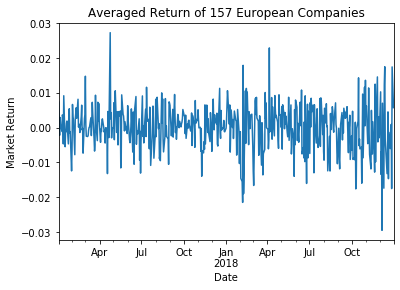

In [ ]:
R_m_t.plot()
plt.xlabel('Date')
plt.ylabel('Market Return')
plt.title('Averaged Return of 157 European Companies');

### Rolling beta
The beta of an investment $i$ at time $t$ is given by ($\beta_{i,t}$) measuring its exposure to the general market. This effect of the expected excess asset returns ($r_i$) to the expected excess market returns ($r_m$) can be formulated as:

\begin{equation}
    \beta_{i} = \frac{Cov(r_i,r_m)}{Var(r_m)}
\end{equation}

The $\beta_i$ at each time instant as a time series $\beta_{i,t}$ can then be made using a rolling window.

For the majority it can be seen the beta value is greater than 1 indicating the higher inclination of the returns to fluctuate with the market. On the other hand, for $0<\beta<1$, it stipulates the asset return will be reluctant to change during market volatility. Moreover, if beta is less than 0 it shows the return will behave in the opposite manner of market variations. 

In [ ]:
B = df['ret'].rolling(22).cov(R_m_t)/np.var(R_m_t)

Text(0.5, 1.0, 'Estimated Rolling Beta of 157 European Companies')

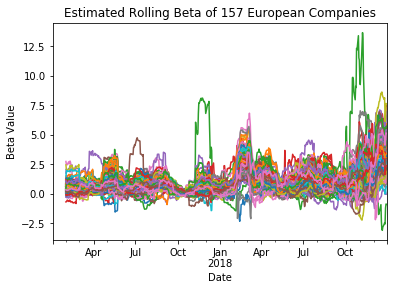

In [ ]:
B.plot(legend = False)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5) #uncomment to add legend
plt.xlabel('Date')
plt.ylabel('Beta Value')
plt.title('Estimated Rolling Beta of 157 European Companies');

### Capital-weighted market return
The capital-weighted market return ($R_m$) has weighting coefficients which can be intepreted as attributing more importance to companies with larger market capital in their overall effect to the market return.

In [ ]:
mcap_total = df['mcap'].sum(axis=1)
cwar = (df['mcap'].mul(df['ret'])).divide(mcap_total,axis=0)
R_m = cwar.sum(axis=1)

Text(0.5, 1.0, 'Cap-Weighted Return of 157 European Companies')

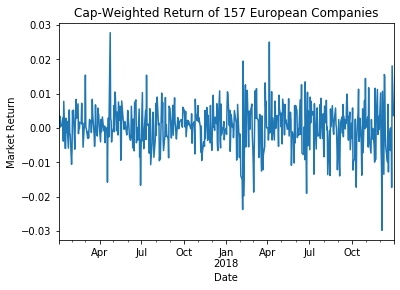

In [ ]:
R_m.plot(legend=False)
plt.xlabel('Date')
plt.ylabel('Market Return')
plt.title('Cap-Weighted Return of 157 European Companies');

### Capital-weighted rolling beta
Using the $R_m$ now to calculate the rolling beta the general trend is followed from the original $\beta$. However, as seen for higher value companies the fluctuations are higher than before as they are now realised with a weighting factor. Intuitively, this makes sense as larger companies are the biggest contributors towards market returns. 

In [ ]:
capmB = df['ret'].rolling(22).cov(R_m)/np.var(R_m)

Text(0.5, 1.0, 'Cap-Weighted Rolling Beta of 157 European Companies')

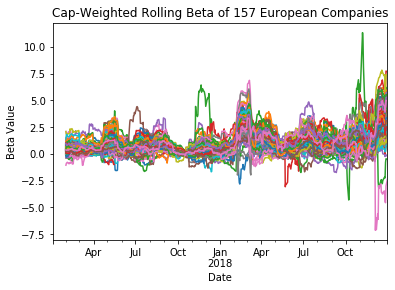

In [ ]:
capmB.plot(legend=False)
plt.xlabel('Date')
plt.ylabel('Beta Value')
plt.title('Cap-Weighted Rolling Beta of 157 European Companies');

### Arbitrage pricing theory (APT) for two-factor models
For the APT-abiding equation given, the two factors the model depends on are $b_s$; the natural logarithm of the company's valuation, and $b_m$; the cap-weighted beta. Since, a factor structure aims to study the influence on the asset return from a series of variables it is a better descriptor than a standard CAPM. Nonetheless, the number of parameters that has to be learnt are increased and also more difficult to obtain. The parameters corresponding to the two factors are found below using cross-sectional regression to be $b_m = -4.625e-7, b_s = 1.428e-6$ and the constant of the model being $0$.

In [ ]:
df.replace([np.inf, -np.inf], np.nan)
df.fillna(0)

bs = np.log(df['mcap'])[21:]
bm = capmB[21:]
variables = [np.array(bm), np.array(bs)]
V = len(variables)
I = df['ret'].shape[1]
S = df['ret'].shape[0] - 21
X = np.array(variables).reshape(V,I,S)
X = np.nan_to_num(X)

y = np.array(df['ret'])[21:,:].reshape(I,S)
y = np.nan_to_num(y)

coeffs = np.zeros((V+1,I,S))
csreg = []

#regression per company i per day t
for i in range(I):
    xreg = []
    for t in range(S):
        tmpreg = LinearRegression(fit_intercept = False).fit(X[:,i,t].reshape(-1,1).T, y[i,t].reshape(1))
        coeffs[:,i,t] = [tmpreg.intercept_, tmpreg.coef_[0], tmpreg.coef_[1]]
        xreg.append(tmpreg)
    csreg.append(xreg)


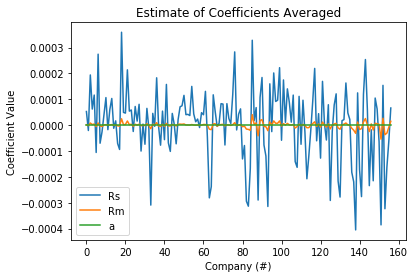

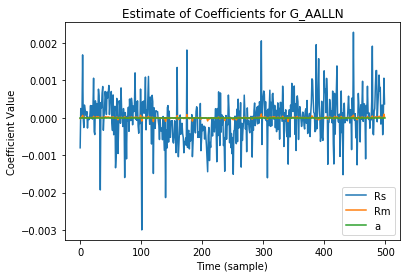

In [ ]:
plt.figure(1)
plt.plot(np.mean(coeffs[2,:,:],axis=1))
plt.plot(np.mean(coeffs[1,:,:],axis=1))
plt.plot(np.mean(coeffs[0,:,:],axis=1))
plt.xlabel('Company (#)')
plt.ylabel('Coefficient Value')
plt.title('Estimate of Coefficients Averaged')
plt.legend(['Rs','Rm','a'])

plt.figure(2)
plt.plot(coeffs[2,1,:])
plt.plot(coeffs[1,1,:])
plt.plot(coeffs[0,1,:])
plt.xlabel('Time (sample)')
plt.ylabel('Coefficient Value')
plt.title('Estimate of Coefficients for G_AALLN')
plt.legend(['Rs','Rm','a']);

The magnitude of the parameters shows the model's sensibility to $\beta_s$ over the cap-weighted beta and the constant. Due to this, it can also be noted $R_m$ has the largest variance relative to the other parameters. 

In [ ]:
a_std = np.mean([np.std(coeffs[0,i,:]) for i in range(I)])
bm_std = np.mean([np.std(coeffs[1,i,:]) for i in range(I)])
bs_std = np.mean([np.std(coeffs[2,i,:]) for i in range(I)])

a_mean = np.mean(np.mean(coeffs[0,:,:]))
bm_mean = np.mean(np.mean(coeffs[1,:,:]))
bs_mean = np.mean(np.mean(coeffs[2,:]))


print('The magnitude of the parameters are:','a =',a_mean,',R_m =',bm_mean,',R_s =',bs_mean)
print('The standard deviation of the parameters are:','\u03C3^2_a =',a_std,', \u03C3^2_R_m =',bm_std,', \u03C3^2_R_s =',bs_std)

The magnitude of the parameters are: a = 0.0 ,R_m = -4.6257897291169574e-07 ,R_s = 1.4284519135342384e-06
The standard deviation of the parameters are: σ^2_a = 0.0 , σ^2_R_m = 4.97652604595455e-05 , σ^2_R_s = 0.0006679824592711777


Calculating the correlation through time of the companies by the scalar product of the specific return $\epsilon_i$ and $r_i$, it is evident there holds little correlation ($<0.025$) and hence no future predictions can be made from past returns.

In [ ]:
e = np.zeros((I,S))
corr = np.zeros((I,S))
for i in range(I):
    for t in range(S):
        e[i,t] = csreg[i][t].predict(X[:,i,t].reshape(-1,1).T)
        corr[i,t] = e[i,t] * np.array(df['ret'])[21+t,i]

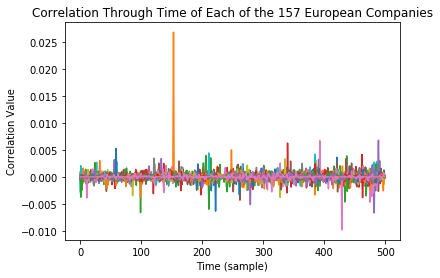

In [ ]:
plt.plot(corr.T)
plt.xlabel('Time (sample)')
plt.ylabel('Correlation Value')
plt.title('Correlation Through Time of Each of the 157 European Companies');

The magnitudes of the covariance matrix $R$ were found to be incredibly small of magnitudes $e-10,e-08,e-07$. Also judging from the eigenvalues of the matrix all being $<1$, the covariance matrix can be concluded as stable.

In [ ]:
R = coeffs[1:,0,:]
covR = np.cov(R)
eigvalR, eigvectR = np.linalg.eig(covR)
print('The eigenvalues of covariance matrix R are:','\u03BB1=',eigvalR[0],',\u03BB2=',eigvalR[1])
pd.DataFrame(covR)

The eigenvalues of covariance matrix R are: λ1= 2.5117791221356215e-10 ,λ2= 4.458286254901258e-07


,0,1
0,8.421645e-10,1.621669e-08
1,1.621669e-08,4.452376e-07


Similarly, the covariance matrix of specific returns $E$ can be calculated. Moreover, principal component analysis (PCA) can be undergo to reduce dimensionality and find the most relevant data through its largest/first component which has value $0.00188$ and variance $5.527\%$

In [ ]:
cov_e = np.cov(e)
eigval_e, eigvect_e = np.linalg.eig(cov_e)
pca = PCA(n_components=100).fit(cov_e)
fcv = pca.singular_values_[0]
fcv_var = 100 * pca.singular_values_[0]/np.sum(pca.singular_values_)
print('The value of the first principal component is ', fcv)
print('The variance of the first principal component is ', fcv_var,'%')

The value of the first principal component is  0.001883866494950761
The variance of the first principal component is  5.527348598670871 %


# Portfolio Optimization <a class="anchor" id="3"></a>

## Adaptive Minimum-Variance Portfolio Optimization <a class="anchor" id="3.1"></a>

### Derivation of optimal weights for minimum variance portfolio

The optimization problem of deriving optimal weights for minimum variance:

\begin{equation}
    min_{\textbf{w}} J(\textbf{w},\textbf{C}) = \frac{1}{2} \textbf{w}^T \textbf{C} \textbf{w}
\end{equation}

and:

\begin{equation}
    \textbf{w}^T \textbf{1} = 1
\end{equation}


The Lagrangian is then:

\begin{equation}
    min_{\textbf{w},\lambda} J'(\textbf{w},\lambda,\textbf{C}) = \frac{1}{2} \textbf{w}^T \textbf{C} \textbf{w} - \lambda (\textbf{w}^T \textbf{1} - 1)
\end{equation}

Taking the gradient w.r.t. $\textbf{w}$ and $\lambda$:

\begin{equation}
    \frac{\partial J'}{\partial \textbf{w}} = \textbf{w}^T \textbf{C} - \lambda \textbf{1}^T = 0
\end{equation}

\begin{equation}
    \frac{\partial J'}{\partial \lambda} = - (\textbf{w}^T \textbf{1} - 1) = 0
\end{equation}

Solving for $\textbf{w}$ in the first of the simultaneous equations:

\begin{equation}
    \textbf{w}^T = \lambda \textbf{1}^T \textbf{C}^{-1}
\end{equation}

and through substitution into the second, $\lambda$ can be solved as:

\begin{equation}
    \lambda \textbf{1}^T \textbf{C}^{-1} \textbf{1} - 1 = 0
\end{equation}

\begin{equation}
    \lambda = \frac{1}{\textbf{1}^T \textbf{C}^{-1} \textbf{1}}
\end{equation}

Now, the other variable $\textbf{w}$ can be solved by substitution into the first of the simultaneous equations:

\begin{equation}
    \textbf{w}^T \textbf{C} = \frac{1}{\textbf{1}^T \textbf{C}^{-1} \textbf{1}} \textbf{1}^T
\end{equation}

\begin{equation}
    \textbf{w}^T = \frac{\textbf{1}^T \textbf{C}^{-1}}{\textbf{1}^T \textbf{C}^{-1} \textbf{1}} 
\end{equation}

The theoretical variance can then be derived as:

\begin{equation}
    \bar{\sigma}^2 = \frac{\textbf{1}^T \textbf{C}^{-1}}{\textbf{1}^T \textbf{C}^{-1} \textbf{1}} \textbf{C} (\frac{\textbf{1}^T \textbf{C}^{-1}}{\textbf{1}^T \textbf{C}^{-1} \textbf{1}})^T
\end{equation}

\begin{equation}
    \bar{\sigma}^2 = \frac{\textbf{1}^T}{\textbf{1}^T \textbf{C}^{-1} \textbf{1}} (\frac{\textbf{1}^T \textbf{C}^{-1}}{\textbf{1}^T \textbf{C}^{-1} \textbf{1}})^T
\end{equation}
    
    

### Portfolio performance using equally-weighted and minimum variance weighted strategies

The train-test split of $0.5$ was made in the time-domain resulting in a time-horizon of $T=260$. Practically, it equates to an investor estimating a portfolio's performance from the previous returns of the assets in the portfolio.

Surprisingly, the minimum variance weighted strategy resulted in higher variance $8.191e-05$ than a more naive equally-weighted strategy $7.930e-05$. This is due to the small amount of data hence making the algorithm unable to ascertain the weights for minimum variance and making it equally as naive. The situation can also be resolved by investing in a more diverse portfolio. Expanding the assets to beyond the last 10 stocks to the entire 157 European companies the variance is reduced to $5.553e-06$ from $5.124e-05$. Moreover, neither approach optimizes for return thus the negative cumulative returns at the end of the time period with it being serendipitous the minimum variance strategy obtained a better return at $-0.119$ compared to the less intelligent equally-weighted $-0.125$.

Less surprisingly, the variance of the minimum variance is higher than the theoretical at $2.862e-05$ because the weights are applied to the testing data. When the weights are applied to the same data it was trained on it reaches the theoretical $2.851e-05$.

In [ ]:
stocks = np.array(df['ret'])[:,-10:].T
T = int(521/2)
train = stocks[:,:T]
test = stocks[:,T:]

C = np.cov(train)
C_inv = np.linalg.inv(C)
ones = np.ones(len(C))

w_mv = np.dot(ones.T,C_inv)/np.dot(np.dot(ones.T,C_inv),ones)
w_equal = ones/len(C)

bar_r_mv = [np.dot(w_mv, test[:,i]) for i in range(T)]
bar_r_equal = [np.dot(w_equal, test[:,i]) for i in range(T)]

R_T_mv = np.cumsum(bar_r_mv)
R_T_equal = np.cumsum(bar_r_equal)

var_mv = np.var(bar_r_mv)
var_equal = np.var(bar_r_equal)

var_mv_theory = np.dot(np.dot(w_mv,C),w_mv.T)

print('The cumulative return of the minimum variance weighted strategy is', R_T_mv[-1])
print('The cumulative return of the equally-weighted strategy is', R_T_equal[-1])

print('The variance of the minimum variance weighted strategy is', var_mv)
print('The variance of the equally-weighted strategy is', var_equal)
print('The theoretical variance of the minimum weighted strategy is', var_mv_theory)

The cumulative return of the minimum variance weighted strategy is -0.11866940298130291
The cumulative return of the equally-weighted strategy is -0.1258651
The variance of the minimum variance weighted strategy is 8.191082334044944e-05
The variance of the equally-weighted strategy is 7.93028236570265e-05
The theoretical variance of the minimum weighted strategy is 2.861629405208285e-05


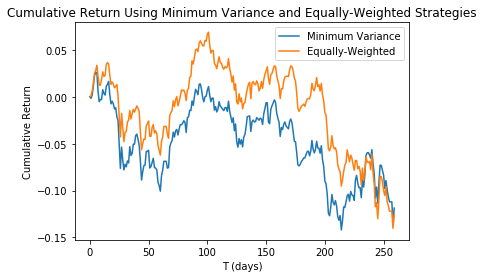

In [ ]:
plt.plot(R_T_mv)
plt.plot(R_T_equal)
plt.xlabel('T (days)')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return Using Minimum Variance and Equally-Weighted Strategies')
plt.legend(['Minimum Variance','Equally-Weighted'])

### Adaptive time-varying minimum variance portfolio

Previously, individual weights were learned for each asset of the portfolio to optimize variance in hopes of greater returns. Further optimizations can be made by producing weights for each asset at each time/day. This time-varying adaptive expansion of the minimum variance strategy can be seen again to produce higher variance $9.494e-05$ but now a positive cumulative return of $0.0055$. The recursive updates follow the rolling window length set; however, the weights calculated at each time instant is uncorrelated with each other and hence the system is not truly adaptive as its not learning from its previous errors which also explains the poor variance. A better method of computing the weights thereby the covariance matrix is to introduce an error between the prediction and ideal measurements then multiplying it by the return and some learning factor and adding it to the weight value to calculate the proceeding weight value and repeating this process to update the weights and reduce the error.

In [ ]:
M = 22
Croll = np.zeros((10,10,T))
Croll_inv = np.zeros((10,10,T))
wroll = np.zeros((10,T))
bar_rroll = np.zeros(T)

for t in range(M, train.shape[1]+1):
    Croll[:,:,t-M] = np.cov(train[:,t-M:t])
    Croll_inv[:,:,t-M] = np.linalg.inv(Croll[:,:,t-M])
    
    wroll[:,t-M] = np.dot(ones.T,Croll_inv[:,:,t-M])/np.dot(np.dot(ones.T,Croll_inv[:,:,t-M]),ones)
    bar_rroll[t-M] = np.dot(wroll[:,t-M], test[:,t-M])

R_T_roll = np.cumsum(bar_rroll)
var_adap = np.var(bar_rroll)

print('The cumulative return of the adaptive time-varying minimum variance weighted strategy is', R_T_roll[-1])
print('The variance of the adaptive time-varying minimum variance weighted strategy is', var_adap)

The cumulative return of the adaptive time-varying minimum variance weighted strategy is 0.005504470068422523
The variance of the adaptive time-varying minimum variance weighted strategy is 9.49359199462135e-05


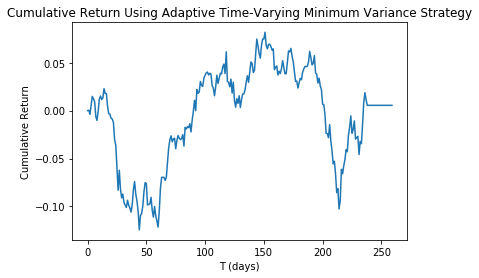

In [ ]:
plt.plot(R_T_roll)
plt.xlabel('T (days)')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return Using Adaptive Time-Varying Minimum Variance Strategy');

# Robust Statistics and Non Linear Methods <a class="anchor" id="4"></a>

## Data Import and Exploratory Data Analysis <a class="anchor" id="4.1"></a>

### Key descriptor statistics and one-day returns

A statistics dataframe is built finding the means, medians and standard deviation of the opening, high, low and closing prices of Apple, IBM, J.P Morgan and the Dow Jones Index. In addition, the returns of each stock was calculated using their respective adjusted close prices.

In [ ]:
apple = pd.read_csv(r'assets/AAPL.csv')
apple = apple.set_index("Date") 
ibm = pd.read_csv(r'assets/IBM.csv')
ibm = ibm.set_index("Date") 
jpm = pd.read_csv(r'assets/JPM.csv')
jpm = jpm.set_index("Date") 
dji = pd.read_csv(r'assets/DJI.csv')
dji = dji.set_index("Date") 

stats = pd.DataFrame()
for i in apple.columns:
    stats['mean ' + i] = [apple[i].mean(), ibm[i].mean(), jpm[i].mean(), dji[i].mean()]
    stats['median '+ i] = [apple[i].median(), ibm[i].median(), jpm[i].median(), dji[i].median()]
    stats['std '+ i] = [apple[i].std(), ibm[i].std(), jpm[i].std(), dji[i].std()]

stats.index = ['AAPL', 'IBM', 'JPM', 'DJI']

apple['ret'] = apple['Adj Close'].pct_change().fillna(0)
ibm['ret'] = ibm['Adj Close'].pct_change().fillna(0)
jpm['ret'] = jpm['Adj Close'].pct_change().fillna(0)
dji['ret'] = dji['Adj Close'].pct_change().fillna(0)

stats

,mean Open,median Open,std Open,mean High,median High,std High,mean Low,median Low,std Low,mean Close,median Close,std Close,mean Adj Close,median Adj Close,std Adj Close,mean Volume,median Volume,std Volume
AAPL,187.686694,186.289993,22.145621,189.561753,187.399994,22.281577,185.823705,184.940002,22.008797,187.711953,186.119995,22.160721,186.174273,184.351776,21.904664,3.270475e+07,29184000.0,1.417972e+07
IBM,138.454382,142.809998,12.114308,139.492072,143.990005,11.913079,137.329243,142.059998,12.204633,138.363108,142.710007,12.028123,134.902751,138.566391,10.671648,5.198937e+06,4237900.0,3.328956e+06
JPM,108.707689,109.180000,5.359081,109.652072,110.529999,5.202870,107.682988,107.790001,5.432537,108.606574,109.019997,5.300480,107.262590,107.219269,4.833316,1.470069e+07,13633000.0,5.349771e+06
DJI,25001.257268,25025.580078,858.834708,25142.041965,25124.099609,815.203959,24846.002226,24883.039063,903.302186,24999.153581,25044.289063,859.132105,24999.153581,25044.289063,859.132105,3.328894e+08,313790000.0,9.407804e+07


### Histogram and probability density function (PDF)

The probability density function (PDF) is simply a normalized version of a histogram over the total number of bins. It is illustrated, the returns follow a normal distribution unlike that of the adjusted close prices which can be seen as a sum of multiple Gaussian distributions.

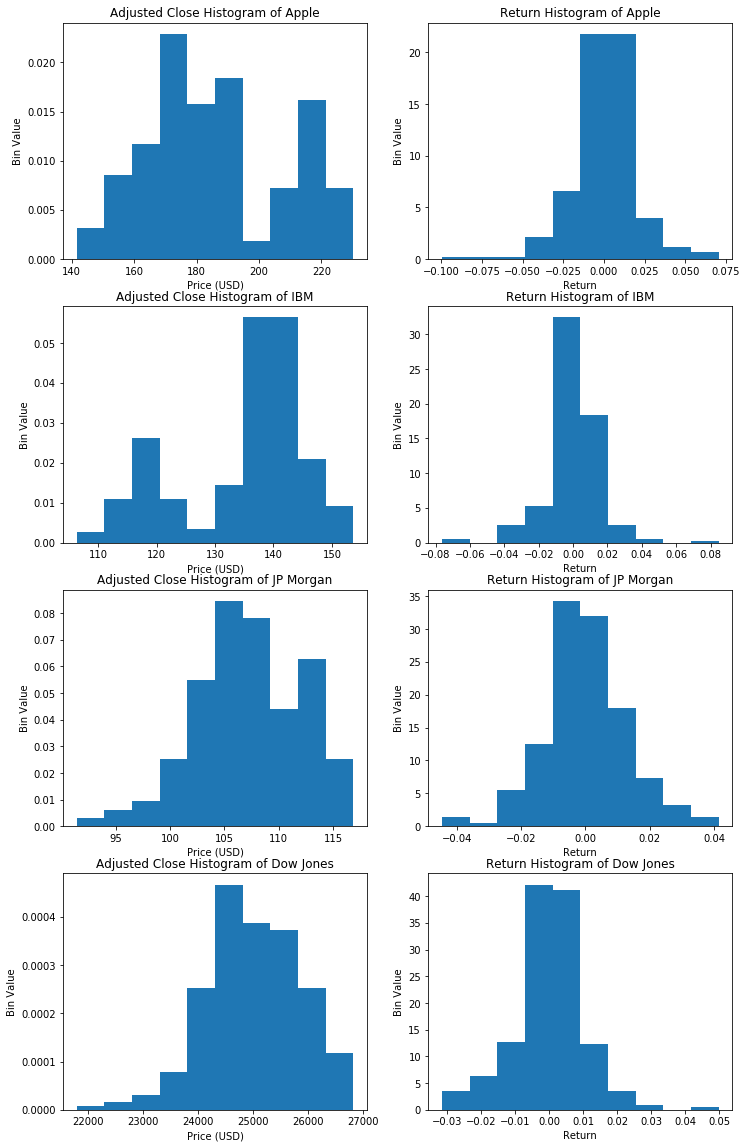

In [ ]:
pdf = True; #set to False if histogram is preferred

plt.figure(figsize=(12,20))

plt.subplot(4,2,1)
plt.hist(apple['Adj Close'], density = pdf)
plt.xlabel('Price (USD)')
plt.ylabel('Bin Value')
plt.title('Adjusted Close Histogram of Apple');

plt.subplot(4,2,2)
plt.hist(apple['ret'], density = pdf)
plt.xlabel('Return')
plt.ylabel('Bin Value')
plt.title('Return Histogram of Apple');

plt.subplot(4,2,3)
plt.hist(ibm['Adj Close'], density = pdf)
plt.xlabel('Price (USD)')
plt.ylabel('Bin Value')
plt.title('Adjusted Close Histogram of IBM');


plt.subplot(4,2,4)
plt.hist(ibm['ret'], density = pdf)
plt.xlabel('Return')
plt.ylabel('Bin Value')
plt.title('Return Histogram of IBM');

plt.subplot(4,2,5)
plt.hist(jpm['Adj Close'], density = pdf)
plt.xlabel('Price (USD)')
plt.ylabel('Bin Value')
plt.title('Adjusted Close Histogram of JP Morgan');


plt.subplot(4,2,6)
plt.hist(jpm['ret'], density = pdf)
plt.xlabel('Return')
plt.ylabel('Bin Value')
plt.title('Return Histogram of JP Morgan');


plt.subplot(4,2,7)
plt.hist(dji['Adj Close'], density = pdf)
plt.xlabel('Price (USD)')
plt.ylabel('Bin Value')
plt.title('Adjusted Close Histogram of Dow Jones');


plt.subplot(4,2,8)
plt.hist(dji['ret'], density = pdf);
plt.xlabel('Return')
plt.ylabel('Bin Value')
plt.title('Return Histogram of Dow Jones');



### Rolling mean, median and standard deviation

The differences between a mean and median approach can be seen as minimal with the given dataset. However, it can be noticed the median absolute deviation (MAD) is less susceptible than the mean standard deviation (STD) having thinner fills which will be further highlighted in the next section. The occurrence of similarility between rolling means and medians is due to the distributions being normal. As seen before, this is not the case for adjusted close prices but due to the time variant introduced by the rolling window the distributions over a 5 day period is.

In [ ]:
apple_roll_mean = apple['Adj Close'].rolling(5).mean()
ibm_roll_mean = ibm['Adj Close'].rolling(5).mean()
jpm_roll_mean = jpm['Adj Close'].rolling(5).mean()
dji_roll_mean = dji['Adj Close'].rolling(5).mean()

apple_roll_std = apple['Adj Close'].rolling(5).std()
ibm_roll_std = ibm['Adj Close'].rolling(5).std()
jpm_roll_std = jpm['Adj Close'].rolling(5).std()
dji_roll_std = dji['Adj Close'].rolling(5).std()

apple_roll_med = apple['Adj Close'].rolling(5).median()
ibm_roll_med = ibm['Adj Close'].rolling(5).median()
jpm_roll_med = jpm['Adj Close'].rolling(5).median()
dji_roll_med = dji['Adj Close'].rolling(5).median()

apple_roll_mad = apple['Adj Close'].rolling(5).apply(pd.DataFrame.mad)
ibm_roll_mad = ibm['Adj Close'].rolling(5).apply(pd.DataFrame.mad)
jpm_roll_mad = jpm['Adj Close'].rolling(5).apply(pd.DataFrame.mad)
dji_roll_mad = dji['Adj Close'].rolling(5).apply(pd.DataFrame.mad)

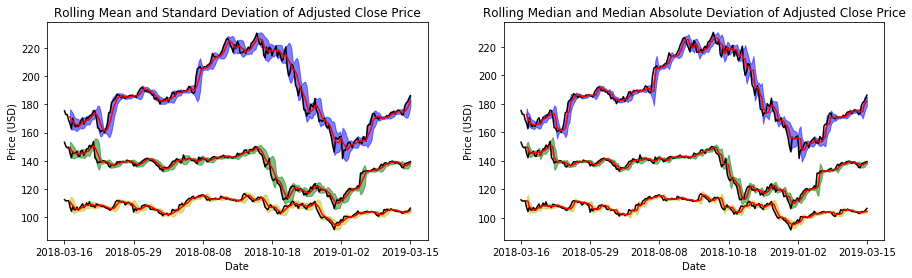

In [ ]:
plt.figure(figsize=(15,4))


plt.subplot(1,2,1)
apple['Adj Close'].plot(color='k')
plt.plot(apple.index,apple_roll_mean, color='r')
plt.fill_between(apple.index,1.5*apple_roll_std+apple_roll_mean, -1.5*apple_roll_std+apple_roll_mean, color='b', alpha = 0.5)

ibm['Adj Close'].plot(color='k')
plt.plot(ibm.index,ibm_roll_mean, color='r')
plt.fill_between(ibm.index,1.5*ibm_roll_std+ibm_roll_mean, -1.5*ibm_roll_std+ibm_roll_mean, color='g', alpha = 0.5)

jpm['Adj Close'].plot(color='k')
plt.plot(jpm.index,jpm_roll_mean, color='r')
plt.fill_between(jpm.index,1.5*jpm_roll_std+jpm_roll_mean, -1.5*jpm_roll_std+jpm_roll_mean, color='y', alpha = 0.5)

plt.ylabel('Price (USD)')
#plt.legend(['AAPL','IBM','JPM'])
plt.title('Rolling Mean and Standard Deviation of Adjusted Close Price');


plt.subplot(1,2,2)
apple['Adj Close'].plot(color='k')
plt.plot(apple.index,apple_roll_med, color='r')
plt.fill_between(apple.index,1.5*apple_roll_mad+apple_roll_med, -1.5*apple_roll_mad+apple_roll_med, color='b', alpha = 0.5)

ibm['Adj Close'].plot(color='k')
plt.plot(ibm.index,ibm_roll_med, color='r')
plt.fill_between(ibm.index,1.5*ibm_roll_mad+ibm_roll_med, -1.5*ibm_roll_mad+ibm_roll_med, color='g', alpha = 0.5)

jpm['Adj Close'].plot(color='k')
plt.plot(jpm.index,jpm_roll_med, color='r')
plt.fill_between(jpm.index,1.5*jpm_roll_mad+jpm_roll_med, -1.5*jpm_roll_mad+jpm_roll_med, color='y', alpha = 0.5)

plt.ylabel('Price (USD)')
plt.title('Rolling Median and Median Absolute Deviation of Adjusted Close Price');

### Outliers

The figure proves as previously suspected MAD is less impacted by the noise compared to STD. This is due to the midpoint value undergoing less variance than a equally weighted sum which involves the outlier. In addition, using a larger rolling window can further help negate the effects as more samples will reduce the presence of outliers.

In [ ]:
outliers = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']

appleo = apple.copy()
ibmo = ibm.copy()
jpmo = jpm.copy()

apple_maxval = max(appleo['Adj Close'])
ibm_maxval = max(ibmo['Adj Close'])
jpm_maxval = max(jpmo['Adj Close'])

for i in outliers:
    appleo.at[i, 'Adj Close'] = 1.2*apple_maxval
    ibmo.at[i, 'Adj Close'] = 1.2*ibm_maxval
    jpmo.at[i, 'Adj Close'] = 1.2*jpm_maxval


appleo_roll_mean = appleo['Adj Close'].rolling(5).mean()
ibmo_roll_mean = ibmo['Adj Close'].rolling(5).mean()
jpmo_roll_mean = jpmo['Adj Close'].rolling(5).mean()

appleo_roll_std = appleo['Adj Close'].rolling(5).std()
ibmo_roll_std = ibmo['Adj Close'].rolling(5).std()
jpmo_roll_std = jpmo['Adj Close'].rolling(5).std()

appleo_roll_med = appleo['Adj Close'].rolling(5).median()
ibmo_roll_med = ibmo['Adj Close'].rolling(5).median()
jpmo_roll_med = jpmo['Adj Close'].rolling(5).median()

appleo_roll_mad = appleo['Adj Close'].rolling(5).apply(pd.DataFrame.mad)
ibmo_roll_mad = ibmo['Adj Close'].rolling(5).apply(pd.DataFrame.mad)
jpmo_roll_mad = jpmo['Adj Close'].rolling(5).apply(pd.DataFrame.mad)

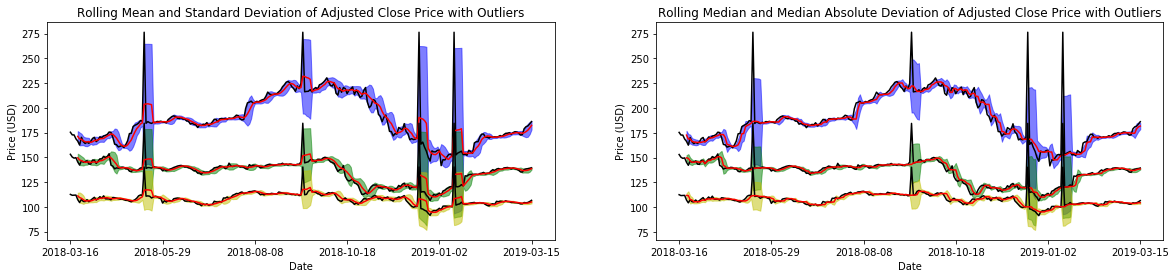

In [ ]:
plt.figure(figsize=(20,4))


plt.subplot(1,2,1)
appleo['Adj Close'].plot(color='k')
plt.plot(appleo.index,appleo_roll_mean, color='r')
plt.fill_between(appleo.index,1.5*appleo_roll_std+appleo_roll_mean, -1.5*appleo_roll_std+appleo_roll_mean, color='b', alpha = 0.5)

ibmo['Adj Close'].plot(color='k')
plt.plot(ibmo.index,ibmo_roll_mean, color='r')
plt.fill_between(ibmo.index,1.5*ibmo_roll_std+ibmo_roll_mean, -1.5*ibmo_roll_std+ibmo_roll_mean, color='g', alpha = 0.5)

jpmo['Adj Close'].plot(color='k')
plt.plot(jpmo.index,jpmo_roll_mean, color='r')
plt.fill_between(jpmo.index,1.5*jpmo_roll_std+jpmo_roll_mean, -1.5*jpmo_roll_std+jpmo_roll_mean, color='y', alpha = 0.5)

plt.ylabel('Price (USD)')
plt.title('Rolling Mean and Standard Deviation of Adjusted Close Price with Outliers');

plt.subplot(1,2,2)
appleo['Adj Close'].plot(color='k')
plt.plot(appleo.index,appleo_roll_med, color='r')
plt.fill_between(appleo.index,1.5*appleo_roll_mad+appleo_roll_med, -1.5*appleo_roll_mad+appleo_roll_med, color='b', alpha = 0.5)

ibmo['Adj Close'].plot(color='k')
plt.plot(ibmo.index,ibmo_roll_med, color='r')
plt.fill_between(ibmo.index,1.5*ibmo_roll_mad+ibmo_roll_med, -1.5*ibmo_roll_mad+ibmo_roll_med, color='g', alpha = 0.5)

jpmo['Adj Close'].plot(color='k')
plt.plot(jpmo.index,jpmo_roll_med, color='r')
plt.fill_between(jpmo.index,1.5*jpmo_roll_mad+jpmo_roll_med, -1.5*jpmo_roll_mad+jpmo_roll_med, color='y', alpha = 0.5)

plt.ylabel('Price (USD)')
plt.title('Rolling Median and Median Absolute Deviation of Adjusted Close Price with Outliers');

### Box plot

A box plot can be a compact summary of a stock. The box encapsulates the interquatile range (IQR) of the stock with the orange line describing its median. The lines at the end of whiskers denote the extremes of the stock. Additionally, a bubble may appear indicating the presence of outliers.

It can be observed then the price of IBM stock is more often than not at upper echeleons of its IQR due to its raised median and has a higher volatility than JPM but lower fluctuations than AAPL due its shorter tails. Finally, the box plot also identifies a possible outlier below the expected price.

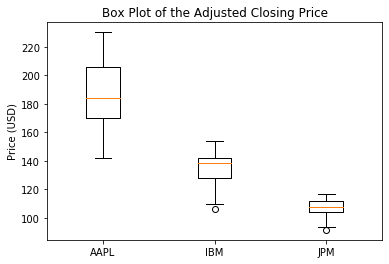

In [ ]:
plt.boxplot([apple['Adj Close'],ibm['Adj Close'],jpm['Adj Close']])
plt.xticks(range(1,4),['AAPL', 'IBM', 'JPM']);
plt.ylabel('Stock')
plt.ylabel('Price (USD)')
plt.title('Box Plot of the Adjusted Closing Price');

## Robust Estimators <a class="anchor" id="4.2"></a>

### Python function of estimators

The functions below allow for the robust estimators using location and scale to deter from the effects of outliers.

In [ ]:
def med(df):
    return df.median()

def iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    return Q3 - Q1

def mad(df):
    return df.mad()

### Computational efficiency

It is experimented that on average the median is the most computationally efficient taking $0.00067$s. By contrast, IQR requires the most amount of time at $0.0026$s and MAD being inbetween at approximately $0.0013$s. Given the complexities of the robust estimators the hierarchy of the results are as expected.

In [ ]:
time1 = time.time()
med(appleo['Adj Close'])
time2 = time.time()
iqr(appleo['Adj Close'])
time3 = time.time()
mad(appleo['Adj Close'])
time4 = time.time()

med_time = time2 - time1
iqr_time = time3 - time2
mad_time = time4 - time3

print('The computational time for calculating the median is', med_time )
print('The computational time for calculating the IQR is', iqr_time )
print('The computational time for calculating the MAD is', mad_time )

The computational time for calculating the median is 0.0006668567657470703
The computational time for calculating the IQR is 0.0025930404663085938
The computational time for calculating the MAD is 0.0012760162353515625


### Breakdown points

The breakdown point measures the robustness of an estimator. It is the point where the percentage of outliers introduced into the data forces the estimator to collapse returning arbitrary values. For the median and MAD estimators the breakdown point is given by $floor(\frac{n-1}{2n})$ as the number of samples $n$ reaches infinity the breakdown point becomes 50%. For the IQR estimator can be viewed as two medians of the first and third quartile; thus, it's breakdown point is 25%.

## Robust and OLS Regression <a class="anchor" id="4.3"></a>

### Ordinary least squares (OLS) regression

The performance of the ordinary least squares (OLS) regression can be measured by $R^2$ the determination of the prediction. For each stock AAPL, IBM and JPM the corresponding $R^2 = 0.519, 0.419, 0.556$ respectively.

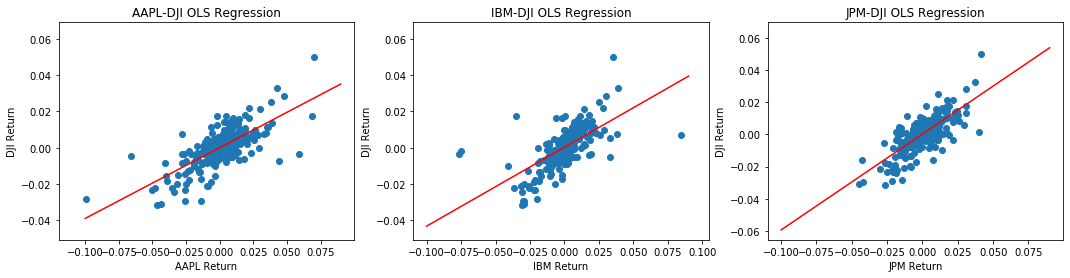

In [ ]:
tickers = ['AAPL', 'IBM', 'JPM']
X = [apple['ret'], ibm['ret'], jpm['ret']]
y = dji['ret']
n = np.arange(-0.1,0.1,0.01)

i = 1
plt.figure(figsize=(18,4))
for x in X:
    ols = LinearRegression().fit(np.array(x).reshape(-1,1),y)
    plt.subplot(1,3,i)
    plt.scatter(x,y)
    plt.plot(n, n * ols.coef_ + ols.intercept_,color='r')
    plt.title(tickers[i-1] + '-DJI OLS Regression')
    plt.xlabel(tickers[i-1] + ' Return')
    plt.ylabel('DJI Return')
    i=i+1

### Huber regression

The Huber loss optimizes the square loss and absolute loss for a set amount of samples. In this manner it remains strongly convex and sensitive while also being highly robust. The $R^2$ values for the stocks are $0.519, 0.363, 0.555$ respectively.

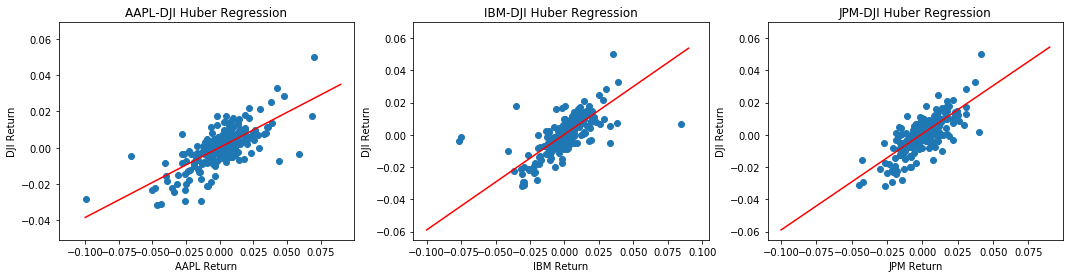

In [ ]:
i = 1
plt.figure(figsize=(18,4))
for x in X:
    ols = HuberRegressor().fit(np.array(x).reshape(-1,1),y)
    plt.subplot(1,3,i)
    plt.scatter(x,y)
    plt.plot(n, n * ols.coef_ + ols.intercept_,color='r')
    plt.title(tickers[i-1] + '-DJI Huber Regression')
    plt.xlabel(tickers[i-1] + ' Return')
    plt.ylabel('DJI Return')
    i=i+1

### Performance of regression methods

From the results above the OLS regressor performs better in every stock than the Huber regressor. This is due to the fact the Huber is robust to outlier and hence for data which contains so few it in general performs worse. 

## Robust Trading Strategies <a class="anchor" id="4.4"></a>

### Moving average crossover

The simple trading strategy is visualised with regions in green being periods to buy while those in red are the points to sell. If the buy/sell is made at the crossover points a positive return is witnessed. For the second row of figures, it shows the effects of outliers on the data making the price time-series more volatile and less predictable and thus a negative return is obtained. 

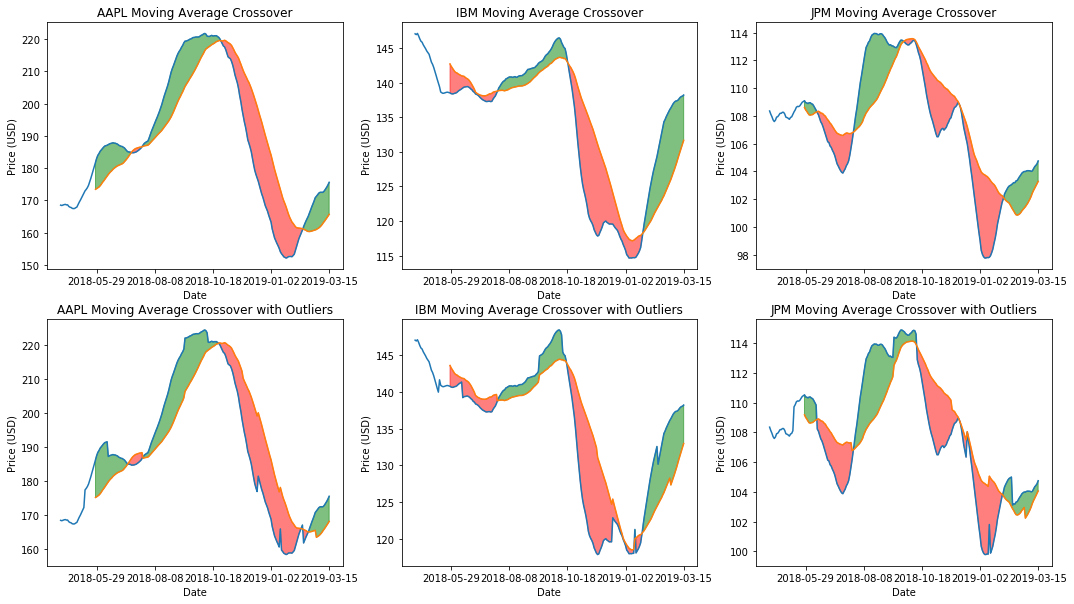

In [ ]:
i = 1
plt.figure(figsize=(18,10))
for x in [apple, ibm, jpm, appleo, ibmo, jpmo]:
    ma20 = x['Adj Close'].rolling(20).mean()
    ma50 = x['Adj Close'].rolling(50).mean()
    
    plt.subplot(2,3,i)
    ma20.plot()
    ma50.plot()
    plt.fill_between(x.index, ma20, ma50, where=ma20>ma50, color='g', alpha=0.5)
    plt.fill_between(x.index, ma20, ma50, where=ma20<ma50, color='r', alpha=0.5)
    
    if i>3:
        plt.title(tickers[i-4] + ' Moving Average Crossover with Outliers')
    else:
        plt.title(tickers[i-1] + ' Moving Average Crossover')
    
    plt.ylabel('Price (USD)')
    
    i = i+1


### Moving median crossover

Using a median trading strategy it can be seen the outliers introduce more crossover points compared to the clean version of the moving average crossover. However, moving median crossover as seen before is far less prone to outliers than its mean partner producing nearly identical plots regardless of the presence of outliers.

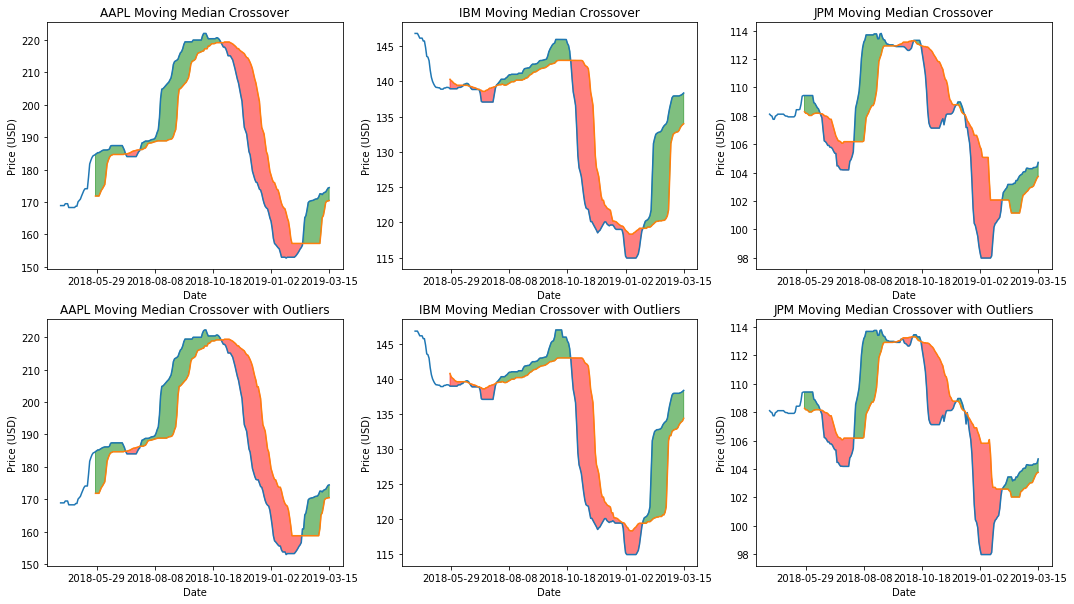

In [ ]:
i = 1
plt.figure(figsize=(18,10))
for x in [apple, ibm, jpm, appleo, ibmo, jpmo]:
    ma20 = x['Adj Close'].rolling(20).median()
    ma50 = x['Adj Close'].rolling(50).median()
    
    plt.subplot(2,3,i)
    ma20.plot()
    ma50.plot()
    plt.fill_between(x.index, ma20, ma50, where=ma20>ma50, color='g', alpha=0.5)
    plt.fill_between(x.index, ma20, ma50, where=ma20<ma50, color='r', alpha=0.5)
    
    if i>3:
        plt.title(tickers[i-4] + ' Moving Median Crossover with Outliers')
    else:
        plt.title(tickers[i-1] + ' Moving Median Crossover')
    
    plt.ylabel('Price (USD)')
    
    i = i+1

# Graphs in Finance <a class="anchor" id="5"></a>

## Stock Selection

The stocks chosen from S&P 500 index are commonly known as the "Big Tech" companies: Apple AAPL, Google GOOG, Amazon AMZN, Microsoft MSFT and Facebook FB. (note: GOOG was chosen over GOOGL to match the non-voting shares of the others)

The criterion is therefore of the same sector, holding the highest market capital and of the same geographical location (country). Due to dominant valuations, they often dictate the markets and each other and hence should prove strong correlation. Besides the stock prices generated from company action and competition, social, political and other economic factors will also be of heavy influence.

It is evident from the log returns the fluctuations are manifested in a similar fashion showing generally each of the companies follow the same projectory as they are influenced by the same factors as stated previously. With idiosyncrancies describing the company's independent operations e.g. Facebook July 2018 ramifications from Cambridge Analytica scandal.

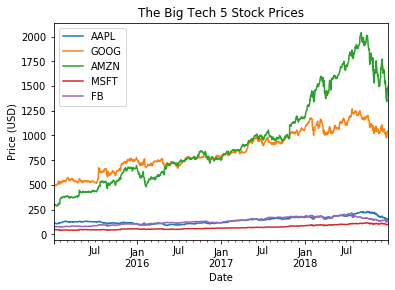

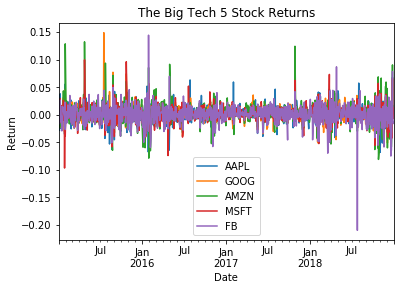

In [ ]:
assets = pd.read_csv('assets/snp_allstocks_2015_2019.csv')
assets.set_index(["Date"], inplace=True)
assets.index = pd.DatetimeIndex(assets.index).to_period('D')

info = pd.read_csv('assets/snp_info.csv')
sector = info['GICS Sub Industry']
tickers = ['AAPL', 'GOOG', 'AMZN', 'MSFT', 'FB']
price = assets[tickers]
returns = np.log(price) - np.log(price.shift(1))

price.plot()
plt.legend(tickers)
plt.title('The Big Tech 5 Stock Prices')
plt.ylabel('Price (USD)')

returns.plot()
plt.legend(tickers);
plt.title('The Big Tech 5 Stock Returns')
plt.ylabel('Return');

## Correlation Network

The role of a correlation matrix is to deduce the relationships between each stock. This can be more clearly shown using a network of nodes to represent the stocks and edges between them to represent a connection or correlation above a certain threshold.

The network demonstrates Google and Microsoft share the most connections which could translate to both company's wide offering of product and services. Whilst, for a company like Apple whose revenue is generated mostly from its hardware products does not have edges to a more services reliant company such as Amazon or to a company with an ad-based revenue model like Facebook. 

,AAPL,GOOG,AMZN,MSFT,FB
AAPL,1.000000,0.516988,0.485394,0.565830,0.455673
GOOG,0.516988,1.000000,0.658465,0.673407,0.605307
AMZN,0.485394,0.658465,1.000000,0.613155,0.564983
MSFT,0.565830,0.673407,0.613155,1.000000,0.512326
FB,0.455673,0.605307,0.564983,0.512326,1.000000


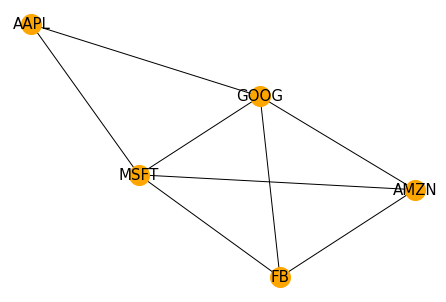

In [ ]:
# Calculate the correlation between individuals. We have to transpose first, because the corr function calculate the pairwise correlations between columns.
corr = returns.corr()
 
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']
links
 
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['value'] > 0.5) & (links['var1'] != links['var2']) ]
links_filtered
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
 
# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

corr

## Graph Topology

Reordering the time series would infact affect the graph topology as the nature of the data determines the correlation between the stocks. However, if the relative order of the time series for each stock was kept the same the correlation matrix would be unaffected and the graph topology would also undoubtly remain the same. Additionally, the only difference in re-ordering the graph vertices would be the index of the stocks in the correlation matrix and location of nodes in the network. Since, such alterations do not affect the actual correlation calculations the same connections will be made as before with only ornamental changes to the topology of the graph.

In [ ]:
return_shuffle = returns.sample(frac=1, random_state=1)
return_shuffle.corr()

,AAPL,GOOG,AMZN,MSFT,FB
AAPL,1.000000,0.516988,0.485394,0.565830,0.455673
GOOG,0.516988,1.000000,0.658465,0.673407,0.605307
AMZN,0.485394,0.658465,1.000000,0.613155,0.564983
MSFT,0.565830,0.673407,0.613155,1.000000,0.512326
FB,0.455673,0.605307,0.564983,0.512326,1.000000


## Different Distance Metrics

Distance metrics other than correlation can be used and thus spectral distance was chosen. Spectral distance is the Euclidean distance of the Fourier transform (FT). The low frequencies of a FT on stock returns correspond to steady fluctuations and slow rates of change in prices meanwhile high frequencies correspond to more volatile behaviour and quick changes in valuation. Hence, two stocks with close distance between their spectrums is analogous to similar behaviour in price fluctuations and is the justification of the choice of the distance metric.

As seen, Amazon now has least amount of edges whilst Google and Microsoft remain as having the most connections. This explains the behaviour of the returns is dissimilar between Amazon and Apple/Facebook; although, the exact frequencies cannot be addressed and thus it is unsure whether the fluctuations are slow or fast unless the power spectral densities are analysed.

Furthermore, due to the nature of FTs requiring the past time samples in its calculations any modification of the time-series will result in inaccurate topologies. Modification of the graph vertices will remain unaffected.

In [ ]:
returns_na = np.array(returns.dropna())
return_fft = np.zeros((returns_na.shape))

for i in range(returns_na.shape[1]):
    return_fft[:,i] = np.abs(np.fft.fft(returns_na[:,i]))

spec_dist = np.zeros((returns_na.shape[1],returns_na.shape[1]))
for i in range(returns_na.shape[1]):
    for j in range(returns_na.shape[1]):
        spec_dist[i,j] = np.linalg.norm(return_fft[:,i]-return_fft[:,j])
        
spec_dist = pd.DataFrame(spec_dist)
spec_dist.index, spec_dist.columns = tickers, tickers
spec_dist


,AAPL,GOOG,AMZN,MSFT,FB
AAPL,0.000000,8.802767,10.409444,8.387072,9.702531
GOOG,8.802767,0.000000,9.413837,7.510649,9.508258
AMZN,10.409444,9.413837,0.000000,9.717137,10.168530
MSFT,8.387072,7.510649,9.717137,0.000000,9.798196
FB,9.702531,9.508258,10.168530,9.798196,0.000000


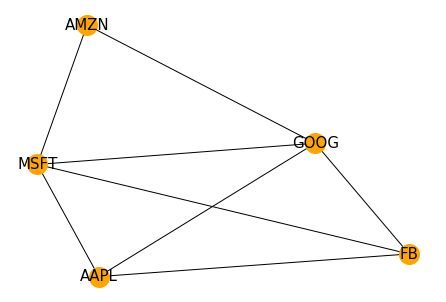

In [ ]:
corr = spec_dist

links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']
links

links_filtered=links.loc[ (links['value'] < 10) & (links['var1'] != links['var2']) ]
links_filtered

G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

## Raw Prices

Using raw prices instead of log returns changes the dynamic from a rate to pure value. The correlation matrix has by all accounts higher values due to the general positive trend of markets hence inducing bias into the data. Otherwise, the topology of the graph has the same relationship with the nature of the data as the log returns. It can also be seen, the raw prices are a poor form to utilize spectral distance as the log returns were a method of normalizing the data and thus produced informational distances.

,AAPL,GOOG,AMZN,MSFT,FB
AAPL,1.000000,0.847447,0.893789,0.915121,0.761691
GOOG,0.847447,1.000000,0.953304,0.955597,0.941334
AMZN,0.893789,0.953304,1.000000,0.984345,0.849083
MSFT,0.915121,0.955597,0.984345,1.000000,0.851468
FB,0.761691,0.941334,0.849083,0.851468,1.000000


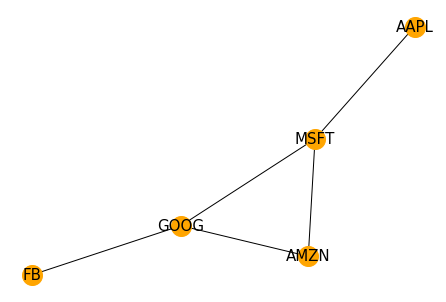

In [ ]:
corr = price.corr()

links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']
links
 

links_filtered=links.loc[ (links['value'] > 0.9) & (links['var1'] != links['var2']) ]
links_filtered

G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

corr

In [ ]:
price_na = np.array(price.dropna())
price_fft = np.zeros((price_na.shape))

for i in range(price_na.shape[1]):
    price_fft[:,i] = np.abs(np.fft.fft(price_na[:,i]))

#plt.plot(price_fft);

spec_dist_price = np.zeros((price_na.shape[1],price_na.shape[1]))
for i in range(price_na.shape[1]):
    for j in range(price_na.shape[1]):
        spec_dist_price[i,j] = np.linalg.norm(price_fft[:,i]-price_fft[:,j])
        
spec_dist_price = pd.DataFrame(spec_dist_price)
spec_dist_price.index, spec_dist_price.columns = tickers, tickers
spec_dist_price

,AAPL,GOOG,AMZN,MSFT,FB
AAPL,0.000000,728394.563073,915608.241460,74409.337335,13070.296118
GOOG,728394.563073,0.000000,277025.010825,801822.577169,735372.725687
AMZN,915608.241460,277025.010825,0.000000,985386.286475,921404.493489
MSFT,74409.337335,801822.577169,985386.286475,0.000000,66900.651711
FB,13070.296118,735372.725687,921404.493489,66900.651711,0.000000
